In [ ]:
pip install qiskit==2.1

In [ ]:
pip install qiskit_aer==0.17

In [ ]:
pip install qiskit_ibm_runtime==0.40

In [ ]:
pip install numpy==2.2

In [ ]:
pip install pylatexenc==2.10

In [ ]:
pip install matplotlib==3.10

# Chapter 15. Experiments for quantum advantage

## 15.1. Random circuit sampling

In [1]:
from qiskit.quantum_info import random_unitary

U = random_unitary(2, seed = 1234).to_matrix()
print(U)

[[-0.65182701+0.35104045j -0.06872086+0.66870741j]
 [ 0.30111103-0.60101938j  0.3613751 +0.64615469j]]


In [2]:
import numpy as np

np.random.seed(1234)
n = 10
n_unitaries = 1000 # Number of unitaries we receive
n_samples = 100 # Number of strings to sample

p_r = [] # Probabilities according to U of the sampled strings 

for i in range(n_unitaries):

    U = random_unitary(2**n, seed = 1234 + i).to_matrix()
    probs = abs(U[:,0])**2

    for j in range(n_samples):
        r = np.random.randint(0,2**n)
        p_r.append(probs[r])

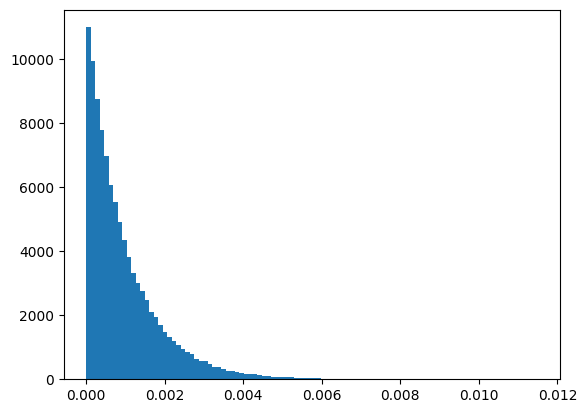

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(p_r, bins = 100)
plt.show()

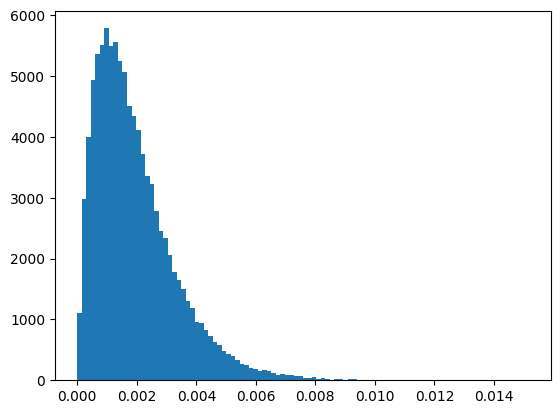

In [4]:
p_s = [] # Probabilities according to U of the sampled strings 

for i in range(n_unitaries):

    U = random_unitary(2**n, seed = 1234 + i).to_matrix()
    probs = abs(U[:,0])**2

    for j in range(n_samples):
        s = np.random.choice(2**n, p = probs) # Sample s according to probs
        p_s.append(probs[s])

plt.hist(p_s, bins = 100)
plt.show()

In [5]:
a_r = round(np.mean(p_r),6)
a_s = round(np.mean(p_s),6)
print("Average probability of uniformly sampled strings:", a_r)
print("Average probability of strings sampled according to U:", a_s)

Average probability of uniformly sampled strings: 0.000976
Average probability of strings sampled according to U: 0.001948


In [6]:
fxeb_r = round(2**n*np.mean(p_r)-1,3)
fxeb_s = round(2**n*np.mean(p_s)-1,3)
print("FXEB of uniformly sampled strings:", fxeb_r)
print("FXEB probability of strings sampled according to U:", fxeb_s)

FXEB of uniformly sampled strings: -0.001
FXEB probability of strings sampled according to U: 0.995


In [7]:
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Statevector

backend = AerSimulator()
sampler = Sampler(seed = 1234)

p_c = [] # Probabilities according to U of the sampled strings

n_circuits = 1000
n_samples = 100
n = 10
n_layers = 1000

for i in range(n_circuits):

    circ = random_circuit(num_qubits = n, depth = n_layers, seed = 1234 + i,
                          max_operands = 2, measure = True)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    t_circ = pm.run(circ)
    job = sampler.run([t_circ], shots = n_samples)
    results = job.result()
    d = results[0].data.c
    v_s = [int(s,2) for s in d.get_bitstrings()]
    circ.remove_final_measurements()
    sv = Statevector(circ)
    for s in v_s:
      p_c.append(abs(sv[int(s)])**2)

print("FXEB", round((2**n)*np.mean(p_c)-1,3))

FXEB 1.04


In [8]:
from qiskit_aer.noise import NoiseModel, pauli_error

noise = NoiseModel()
p_error = 0.02
error_meas = pauli_error([("X", p_error), ("I", 1 - p_error)])
noise.add_all_qubit_quantum_error(error_meas , "measure")

noise_options = {"backend_options": {"noise_model": noise}}

sampler = Sampler(seed = 1234, options = noise_options)

p_c = [] # Probabilities according to U of the sampled strings